# Import Library

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, VisualRepresentation, MaximalMarginalRelevance, PartOfSpeech
from bertopic.backend import MultiModalBackend
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from umap import UMAP
import hdbscan
import base64
from io import BytesIO
from IPython.display import HTML

# Process Datasets

In [2]:
TRAIN_FOLDER = 'Datasets/RawData/train'
TEST_FOLDER = 'Datasets/RawData/test'
VALID_FOLDER = 'Datasets/RawData/valid'

In [3]:
def load_image_paths_and_annotations_without_memory(image_folder: str, annotation_file: str) -> tuple:
    """
    Load image paths and annotations.
    :param image_folder: Folder containing the images.
    :param annotation_file: CSV file containing the annotations.
    :return: Tuple containing a list of image paths and a pandas DataFrame containing the annotations.
    """
    annotations = pd.read_csv(annotation_file)
    image_paths = []
    labels = []

    for _, row in tqdm(annotations.iterrows(), total=annotations.shape[0], desc='Loading image paths'):
        try:
            img_filename = row['filename']
            img_path = os.path.join(image_folder, img_filename)
            if os.path.exists(img_path):
                image_paths.append(img_path)
                labels.append(row['class'])
            else:
                print(f'Image file {img_filename} does not exist at {img_path}')
        except Exception as e:
            print(f'Error processing image {img_filename}: {e}')
            continue

    return image_paths, labels, annotations

def image_base64(im: str) -> str:
    """
    Convert an image to base64.
    :param im: Path to the image.
    :return: Base64 encoding of the image.
    """
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im: str) -> str:
    """
    Display an image in a Jupyter notebook.
    :param im: Path to the image.
    :return: HTML image tag.
    """
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [4]:
test_images, test_labels, test_annotations = load_image_paths_and_annotations_without_memory(TEST_FOLDER, os.path.join(TEST_FOLDER, '_annotations.csv'))
val_images, val_labels, val_annotations = load_image_paths_and_annotations_without_memory(VALID_FOLDER, os.path.join(VALID_FOLDER, '_annotations.csv'))
train_images, train_labels, train_annotations = load_image_paths_and_annotations_without_memory(TRAIN_FOLDER, os.path.join(TRAIN_FOLDER, '_annotations.csv'))

Loading image paths: 100%|██████████| 369/369 [00:00<00:00, 4053.85it/s]


Image file cocaine-powder-lines-rolled-banknote-and-drugs-in-plastic-bag-pocket-on-black-glass-surface-background-top-view-drug-addiction-concept-2NTT1Y1_jpg.rf.bf560732a757cb000614866c7fa8fc30.jpg does not exist at Datasets/RawData/test\cocaine-powder-lines-rolled-banknote-and-drugs-in-plastic-bag-pocket-on-black-glass-surface-background-top-view-drug-addiction-concept-2NTT1Y1_jpg.rf.bf560732a757cb000614866c7fa8fc30.jpg


Loading image paths:  30%|███       | 798/2631 [00:00<00:00, 3571.07it/s]

Image file drugs-narcotics-business-concept-cocaine-plastic-packets-gun-us-dollars-banknotes-table-white-powder-addiction-crime_771335-12925_jpg.rf.4c4ad70061bde378530068b3c0e43156.jpg does not exist at Datasets/RawData/train\drugs-narcotics-business-concept-cocaine-plastic-packets-gun-us-dollars-banknotes-table-white-powder-addiction-crime_771335-12925_jpg.rf.4c4ad70061bde378530068b3c0e43156.jpg


Loading image paths: 100%|██████████| 2631/2631 [00:00<00:00, 3734.37it/s]

Image file drugs-and-dollars-on-glass-black-table-narcotic-powder-divided-into-stripes-on-a-mirrored-table-one-hundred-dollar-tube-for-drug-use-2FMY1GY_jpg.rf.c501c958fefe6e5f2ced1d5d7ffd6231.jpg does not exist at Datasets/RawData/train\drugs-and-dollars-on-glass-black-table-narcotic-powder-divided-into-stripes-on-a-mirrored-table-one-hundred-dollar-tube-for-drug-use-2FMY1GY_jpg.rf.c501c958fefe6e5f2ced1d5d7ffd6231.jpg


In [5]:
images = train_images + test_images + val_images
labels = train_labels + test_labels + val_labels

# Prepare Model

## Pre-Compute embeddings

In [9]:
embedding_model = MultiModalBackend('clip-ViT-B-32', batch_size=32)
embedd = embedding_model.embed(documents=labels, images=images, verbose=True)
embedd_only_images = embedding_model.embed_images(images=images, verbose=True)
np.savez_compressed('Embeddings/embedding_images.npz', embedd)
np.savez_compressed('Embeddings/embedding_only_images.npz', embedd_only_images)

100%|██████████| 117/117 [10:10<00:00,  5.22s/it]


In [12]:
with np.load('Embeddings/embedding_only_images.npz') as data1, np.load('Embeddings/embedding_images.npz') as data2:
    embedd_only_images = data1['arr_0']
    embedd = data2['arr_0']

## Build BERTopic Model

In [20]:
mmr = MaximalMarginalRelevance(diversity=0.2)
kw = KeyBERTInspired()
part_of_speech = PartOfSpeech("en_core_web_sm")
vectorizer_model = CountVectorizer(stop_words="english")
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
umap_model = UMAP(n_neighbors=20, n_components=10, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=100, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Embeddings image models
embedding_model = MultiModalBackend('clip-ViT-B-32', batch_size=32)

# Visual model
visual_model = VisualRepresentation(image_to_text_model="nlpconnect/vit-gpt2-image-captioning", nr_samples=500, nr_repr_images=20, image_height=800)

representation_model = {
   "Visual_Aspect":  visual_model,
   "KeyBERTInspired": kw,
   "MaximalMarginalRelevance": mmr
}

topic_model = BERTopic(
                      min_topic_size=50,
                      top_n_words=5,
                      n_gram_range=(1, 3),
                      representation_model=representation_model,
                      vectorizer_model=vectorizer_model,
                      ctfidf_model=ctfidf_model,
                      embedding_model=embedding_model,
                      umap_model=umap_model,
                      hdbscan_model=hdbscan_model,
                      verbose=True)

topics, probs = topic_model.fit_transform(documents=labels, images=images, embeddings=embedd_only_images)

# Show Results

In [ ]:
topic_model.topic_aspects_["Visual_Aspect"]

{-1: <PIL.Image.Image image mode=RGB size=1069x600>,
 0: <PIL.Image.Image image mode=RGB size=600x600>,
 1: <PIL.Image.Image image mode=RGB size=837x600>,
 2: <PIL.Image.Image image mode=RGB size=398x600>,
 3: <PIL.Image.Image image mode=RGB size=600x600>,
 4: <PIL.Image.Image image mode=RGB size=789x600>,
 5: <PIL.Image.Image image mode=RGB size=870x600>,
 6: <PIL.Image.Image image mode=RGB size=600x600>,
 7: <PIL.Image.Image image mode=RGB size=1148x600>,
 8: <PIL.Image.Image image mode=RGB size=781x600>}

,Topic,Count,Representation,Visual_Aspect
0,-1,142,"[towels, pile, floor, paper, on, of, teddy, types, different, bunch]",
1,0,2671,"[black, white, and, checkered, photo, hydrant, fire, object, holding, person]",
2,1,403,"[piece, paper, it, with, of, needle, holding, person, knife, bag]",
3,2,169,"[man, in, shirt, the, standing, pants, field, snow, skateboard, tie]",
4,3,96,"[shirt, is, in, black, store, computer, working, hat, woman, person]",
5,4,74,"[suit, to, next, in, tie, woman, man, standing, and, people]",
6,5,58,"[around, their, girls, are, table, wii, playing, game, two, people]",
7,6,43,"[checkered, white, and, row, black, of, tennis, numbered, balls, ]",
8,7,36,"[group, large, together, people, standing, of, crowd, around, , ]",
9,8,35,"[train, walking, down, platform, luggage, with, woman, women, two, sidewalk]",

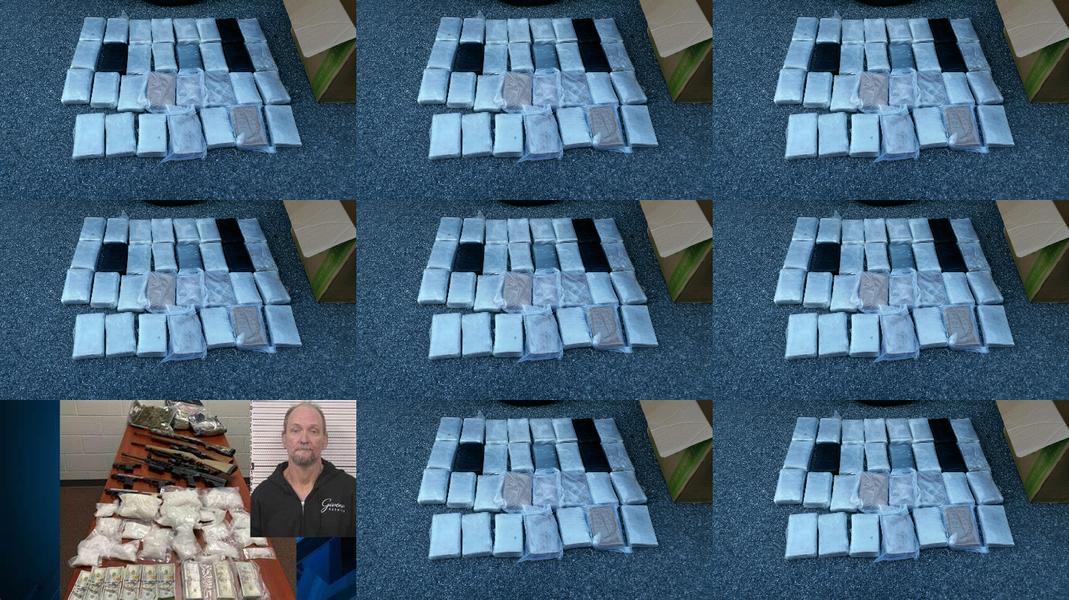
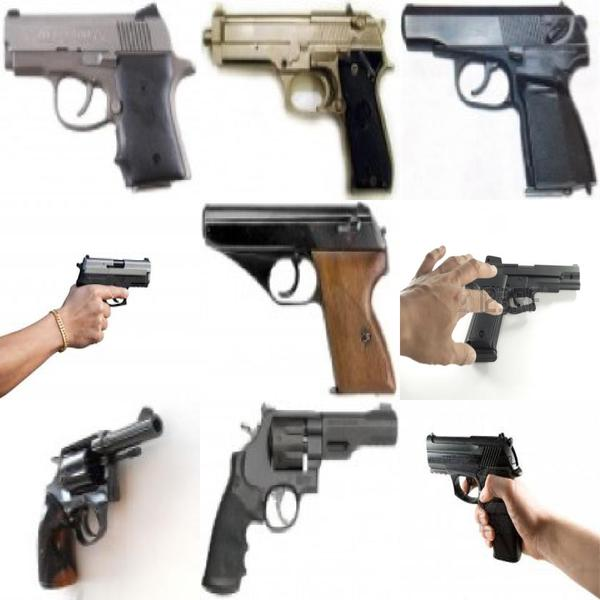
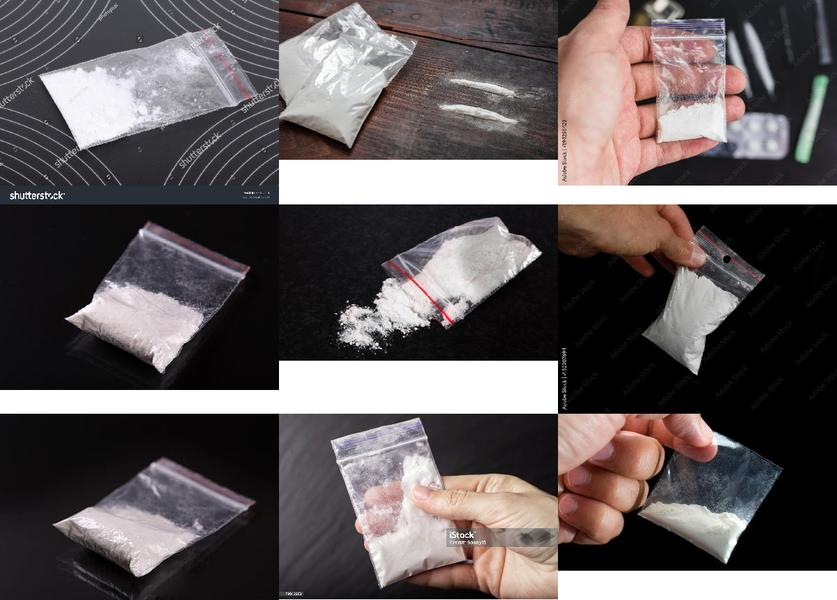
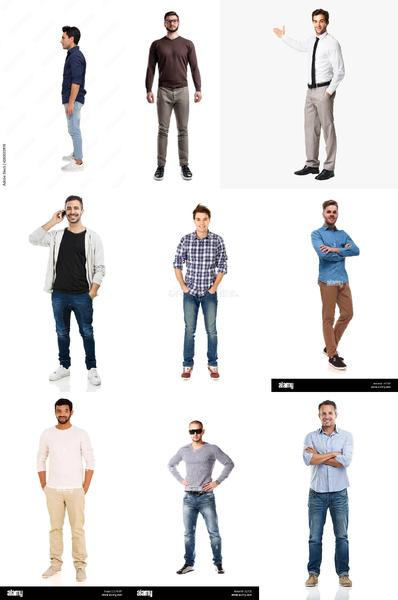
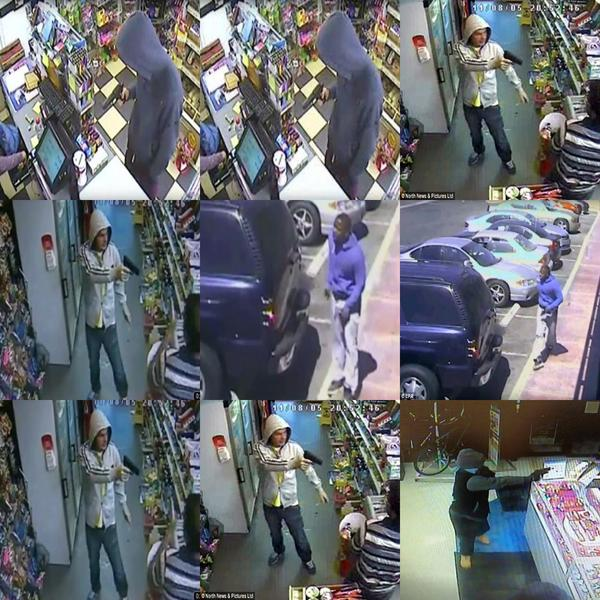
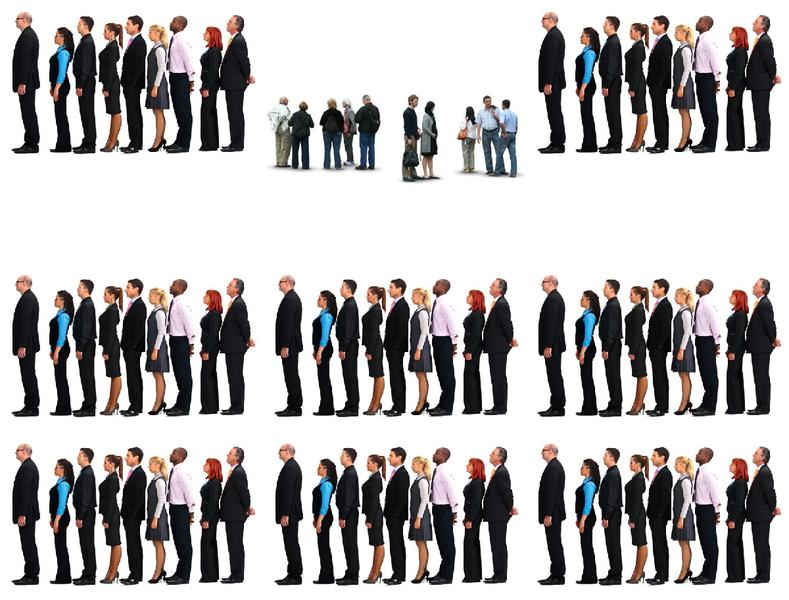
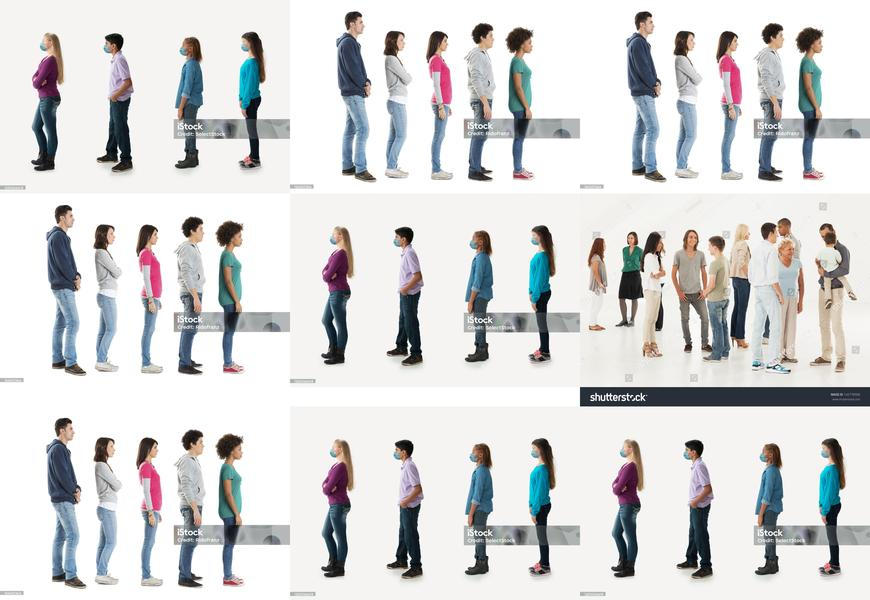
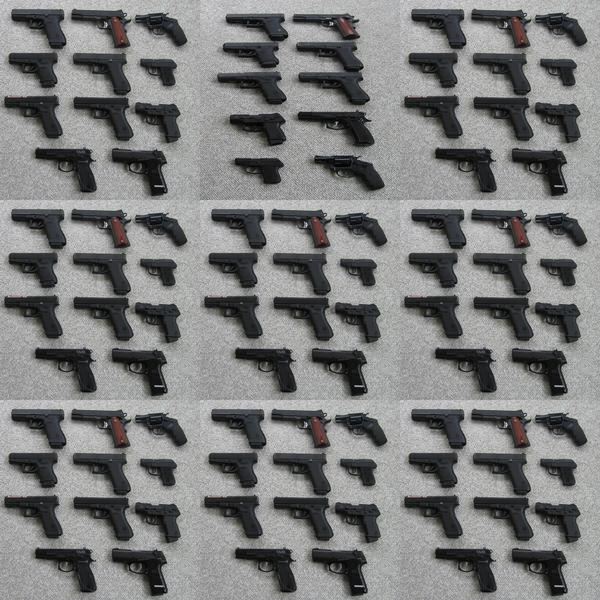
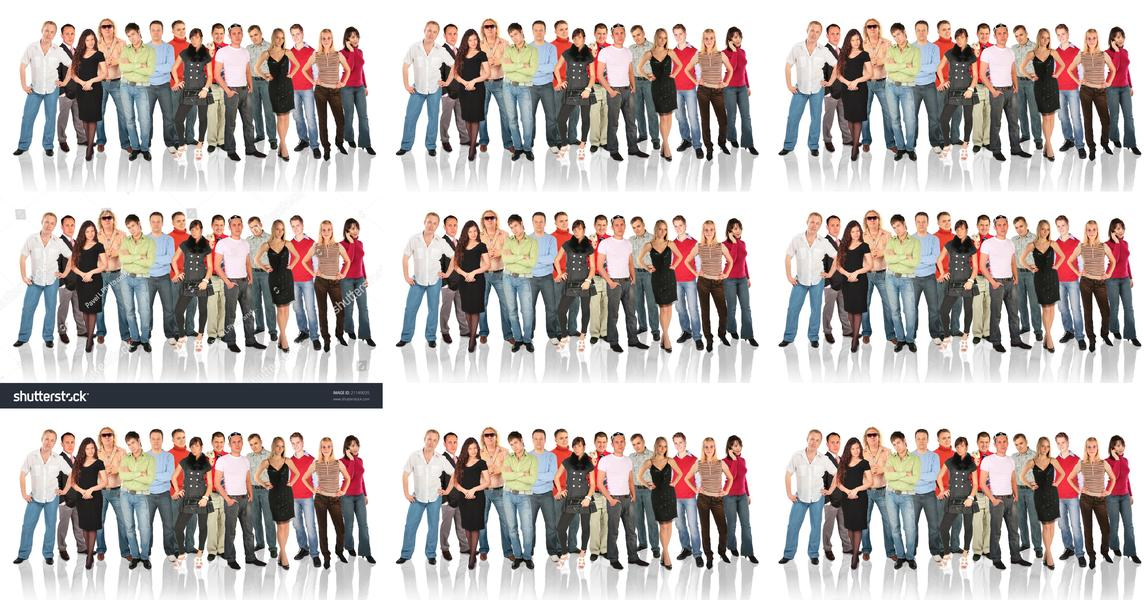
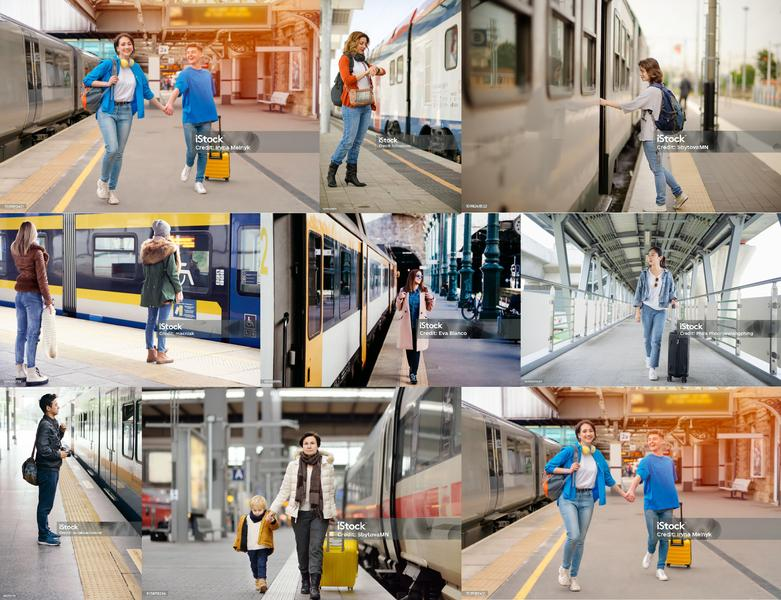

In [ ]:
# Extract dataframe
df = topic_model.get_topic_info().drop(["Representative_Docs", "Name"], axis=1)

# Visualize the images
HTML(df.to_html(formatters={'Visual_Aspect': image_formatter}, escape=False))